In [2]:
#!/usr/bin/env python
"""
Demo for 1D Deblurring test problem on a small scale problem
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna Ugwu"
__affiliations__ = 'Tufts University, University of Bath, Arizona State University, and Tufts University'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "GPL"
__version__ = "1.0"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk; csanderf@asu.edu; connorsanderford@gmail.com; Ugochukwu.Ugwu@tufts.edu"

In [3]:
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import os
import astra
from venv import create
import pylops
from scipy.ndimage import convolve
from trips.test_problems.Deblurring1D import *
from trips.utilities.operators import *
from trips.utilities.helpers import *
from trips.solvers.GKS import *
from trips.solvers.MMGKS import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Hybrid_LSQR import *

#### In this notebook we illustrate how to use the Deblurring1D class. The main features are:
1. Define a Deblurring1D problem where the forward operator can be formed explicitly as a matrix
 - 1.0 We compute the naive solution
 - 1.1 We show how to compute the SVD and the truncated SVD solution
 - 1.2 We use regularization methods for computing an approximate solution
   - 1.2.1. Hybrid_GMRES
   - 1.2.2. MMGKS


#### 1. Define e Deblurring1D problem where the forward operator can be accessed explicitly as a matrix

###### We define an operator, choose an image of any given size and plot the true image and the blurred and noisy data as follows:

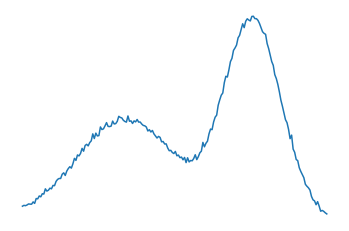

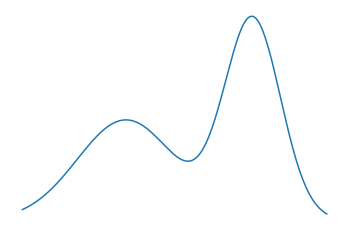

<Figure size 432x288 with 0 Axes>

In [4]:
Deblur1D = Deblurring1D(CommitCrime = True)
nx = 200
x_true = Deblur1D.gen_xtrue(nx, test = 'curve0')
## If you would like to create the operator only
A = Deblur1D.forward_Op_1D(x_true, parameter = 1, nx = nx) 
## The following creates the data b_true
b_true = Deblur1D.gen_data(x_true)
(d, delta) = Deblur1D.add_noise(b_true, 'Gaussian', noise_level = 0.02)
b_vec = d.reshape((-1,1))
Deblur1D.plot_data(d)
Deblur1D.plot_rec(x_true)

##### 1.0. Compute the naive solution

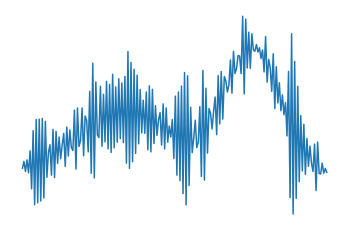

<Figure size 432x288 with 0 Axes>

In [5]:
x_naive = np.linalg.solve(A.todense(), b_vec)
Deblur1D.plot_rec(x_naive)

###### Display the true image, the blurred image, the blurred and noisy image, and the naive reconstructed solution

(-9.950000000000001, 208.95, -0.06209521611869452, 2.1447112805387594)

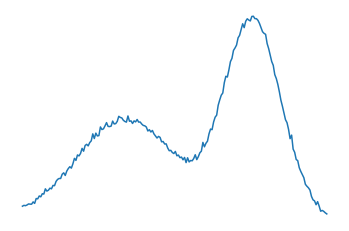

In [6]:
plt.plot(d)
plt.set_cmap('inferno')
plt.axis('off')

##### 1.1. Compute the SVD of the operartor $A$ and plot the singlar values and the singular vectors
###### If the parameter is 'A' then we give the full operator to the function plot_singular_values_svd. The SVD is then computed and the singlar values are plotted. If the parameter is 'S' then we have precomputed the SVD from which we have S and the function plot_singular_values_svd will only plot the singular values. The same applies for plotting the singular vectors. If the operaror is not given, we give the matrix V.

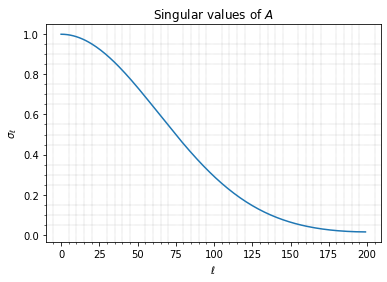

In [7]:
# If the operator is sparse, we convert it to dense A.todense()
plot_singular_values_svd(Operator = A , parameter = 'A')
# If the operator is in the matrix form, but very large and sparse, the following commands can be used to compute the SVD
# import scipy
# [U, S, V] = scipy.sparse.linalg.svds(A, 100)
# 100 defines the number of singular values to be computed

##### 1.1. Compute the truncated SVD solution of a problem by specifying how many singular values you want to keep after truncation

(-9.950000000000001, 208.95, -0.08190400679956333, 2.1583597050240604)

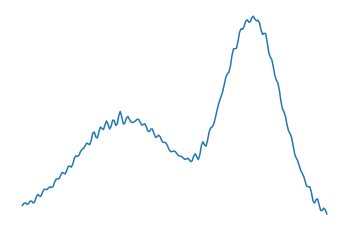

In [8]:
truncated_value = 100
b_vec = d.reshape((-1,1))
(x_tsvd, truncated_value) = TruncatedSVD_sol(A.todense(), b_vec, regparam = truncated_value, delta = delta)
plt.plot(x_tsvd)
plt.axis('off')

In [9]:
truncated_value

100

- 1.2 We use regularization methods for computing an approximate solution
   - 1.2.1. Hybrid_GMRES
   - 1.2.2. Hybrid_LSQR
   - 1.2.3. MMGKS

##### Illustrate the ill-posedness of some inverse problem examples and show the need for regularization
<p>In this example we illustrate the following:

Solve the regularized problem with Hybrid_GMRES, Hybrid_LSQR

$\|\mathbf A{\mathbf x} - {\mathbf b}\|^2_2 + \lambda \|\mathbf L\mathbf x\|_2^2$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator for GKS and $L = I$ for Hybrid_lsqr, for an computed value of the regularization parameter $\lambda$. 


In [10]:
b_vec = d.reshape((-1,1))
(x_hybrid_gmres, info_hybrid_gmres) = Hybrid_GMRES(A, b_vec, n_iter = 100, regparam = 'dp', x_true = x_true, delta = delta)

running Arnoldi algorithm...:   0%|          | 0/100 [00:00<?, ?it/s]

running Arnoldi algorithm...: 100%|██████████| 100/100 [00:00<00:00, 169.08it/s]


Solve the regularized problem with MMGKS

$\|\mathbf A{\mathbf x} - {\mathbf b}\|_2 + \lambda \|\mathbf L\mathbf x\|_q$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator, for an optimal value of $\lambda$. The value of $q$ can be choosen from (0, 2].

In [13]:
k = 3
L = first_derivative_operator(nx)
xtGSVD = tgsvd_tik_sol(A.todense(),L.todense(),b_vec,k)

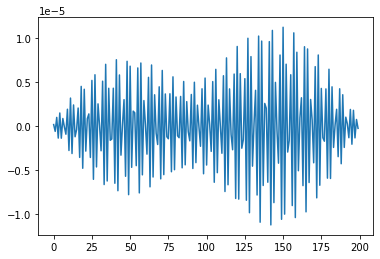

In [14]:
plt.plot(xtGSVD)

In [15]:
def tgsvd_tik_sol(A,L,b_vec,k):
    mu = 0.01
    U, _, Z, C, S = gsvd(A,L) 
    Y = np.linalg.inv(Z.T)[:,0:k]
    CC = C[0:k,0:k]
    SS = S[0:k,0:k]
    UU = U.T[0:k,:]
    xsol = Y@np.linalg.inv(CC.T@CC+1/mu*SS.T@SS)@CC.T@(UU@b_vec)
    return xsol

In [19]:
L = first_derivative_operator(nx)
def gsvd_tik_sol(A,L,b_vec,mu):
    U, _, Z, C, S = gsvd(A,L) 
    Y = np.linalg.inv(Z.T)
    xsol = Y@np.linalg.inv(C.T@C+1/mu*S.T@S)@C.T@(U.T@b_vec)
    return xsol
mu = 0.0001
xsol = (A,L,b_vec,mu)

In [20]:
xsol[2]

array([[0.11652366],
       [0.12516488],
       [0.12176581],
       [0.12877466],
       [0.1393807 ],
       [0.13745308],
       [0.13683643],
       [0.1603089 ],
       [0.14496754],
       [0.19429064],
       [0.19124655],
       [0.22038556],
       [0.21183564],
       [0.24295547],
       [0.23988685],
       [0.29270771],
       [0.26973973],
       [0.27878477],
       [0.29991191],
       [0.29266004],
       [0.32754678],
       [0.32488672],
       [0.36822615],
       [0.38839011],
       [0.39790279],
       [0.39778604],
       [0.44097984],
       [0.45513418],
       [0.42860092],
       [0.4728677 ],
       [0.49887533],
       [0.51728237],
       [0.50290974],
       [0.54651622],
       [0.60179096],
       [0.5817068 ],
       [0.63667954],
       [0.6267322 ],
       [0.65199688],
       [0.70337834],
       [0.67480837],
       [0.73265428],
       [0.7446344 ],
       [0.72855056],
       [0.7622199 ],
       [0.77989772],
       [0.85068442],
       [0.803

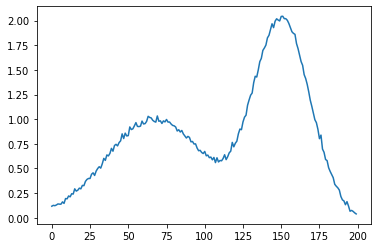

In [21]:
plt.plot(xsol[2])

In [22]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = first_derivative_operator(nx)
data_vec = d.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks, info_mmgks) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=1, n_iter = 100, regparam = 'gcv', x_true = x_true.reshape(-1,1), delta = delta)

running MMGKS...: 100%|██████████| 100/100 [00:03<00:00, 30.32it/s]


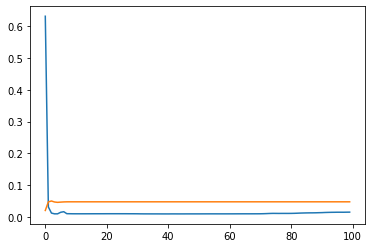

In [23]:
plt.plot(info_mmgks['relError'])
# plt.plot(info_hybrid_lsqr['relError'])
plt.plot(info_hybrid_gmres['relError'])

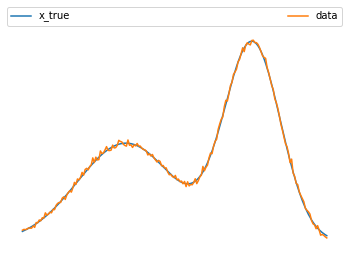

In [24]:
plot_x_true = plt.plot(x_true, label = 'x_true')
plot_tsvd = plt.plot(d, label = 'data')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.axis('off')
plt.show()

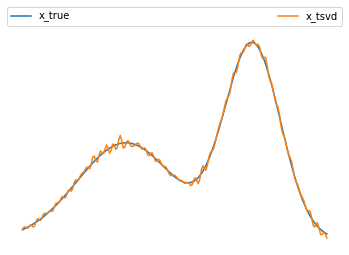

In [25]:
plot_x_true = plt.plot(x_true, label = 'x_true')
plot_tsvd = plt.plot(x_tsvd, label = 'x_tsvd')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.axis('off')
plt.show()

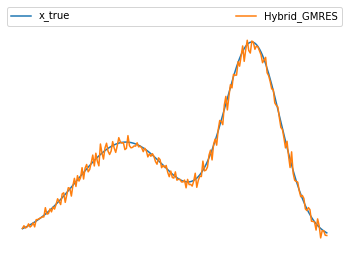

In [26]:
plot_x_true = plt.plot(x_true, label = 'x_true')
plot_hybrid_gmres = plt.plot(x_hybrid_gmres, label = 'Hybrid_GMRES')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.axis('off')
plt.show()

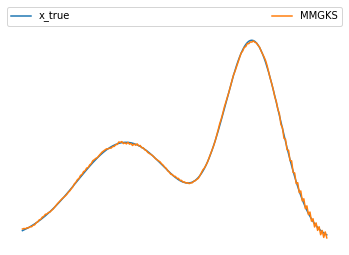

In [27]:
plot_tsvd = plt.plot(x_true, label='x_true')
plot_mmgks = plt.plot(x_mmgks, label='MMGKS')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.axis('off')
plt.show()

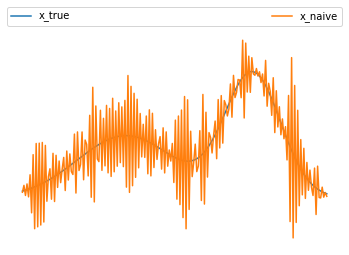

In [28]:
plot_tsvd = plt.plot(x_true, label='x_true')
plot_mmgks = plt.plot(x_naive, label='x_naive')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.axis('off')
plt.show()